# Visual Question Answering using Multimodal Transformer Models

## Import necessary libraries & set up the environment

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 17.4 MB/s eta 0:00:00


In [3]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.8 MB/s eta 0:00:00


In [4]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel,            
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)

# import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score

In [5]:
# SET CACHE FOR HUGGINGFACE TRANSFORMERS + DATASETS
os.environ['HF_HOME'] = os.path.join(".", "cache")
# SET ONLY 1 GPU DEVICE
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

set_caching_enabled(True)
logging.set_verbosity_error()

<ipython-input-5-705839fc65d9>:6: FutureWarning: set_caching_enabled is deprecated and will be removed in the next major version of datasets. Use datasets.enable_caching() or datasets.disable_caching() instead. This function will be removed in a future version of datasets.
  set_caching_enabled(True)


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
#     print('Memory Usage:')
#     print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
#     print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

cuda:0
Tesla T4


## Load the Processed [DAQUAR Dataset](https://www.mpi-inf.mpg.de/departments/computer-vision-and-machine-learning/research/vision-and-language/visual-turing-challenge/)

All the questions have 1-word/phrase answer, so we consider the entire vocabulary of answers available (*answer space*) & treat them as labels. This converts the visual question answering into a multi-class classification problem.

In [7]:
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset","/content/drive/MyDrive/Data Science/archive/data_train.csv"),
        "test": os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "/content/drive/MyDrive/Data Science/archive/data_eval.csv")
    }
)

with open(os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "/content/drive/MyDrive/Data Science/archive/answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-46cc788d42e29e2c/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/6795 [00:00<?, ? examples/s]

Map:   0%|          | 0/5673 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 6795
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 5673
    })
})

### Look at some of the Question/Image/Answer combinations

In [8]:
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    image = Image.open(os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "/content/drive/MyDrive/Data Science/archive/images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

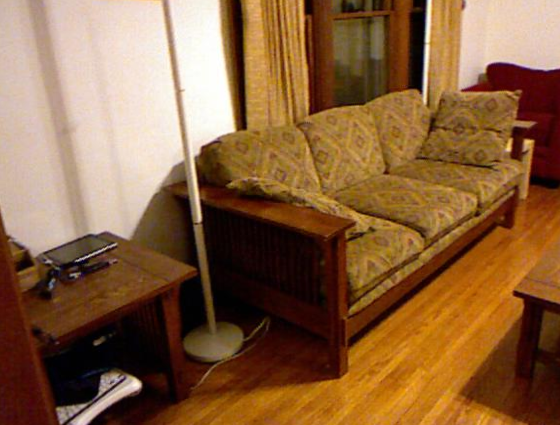

Question:	 what is the colour of the chair
Answer:		 red (Label: 414)


In [9]:
showExample()

### Create a Multimodal Collator for the Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This will be used in the `Trainer()` to automatically create the `Dataloader` from the dataset to pass inputs to the model

The collator will process the **question (text)** & the **image**, and return the **tokenized text (with attention masks)** along with the **featurized image** (basically, the **pixel values**). These will be fed into our multimodal transformer model for question answering.

In [10]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]):
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]):
        processed_images = self.preprocessor(
            images=[Image.open(os.path.join("..","input","visual-question-answering-computer-vision-nlp","dataset", "/content/drive/MyDrive/Data Science/archive/images", image_id + ".png")).convert('RGB') for image_id in images],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }
            
    def __call__(self, raw_batch_dict):
        return {
            **self.tokenize_text(
                raw_batch_dict['question']
                if isinstance(raw_batch_dict, dict) else
                [i['question'] for i in raw_batch_dict]
            ),
            **self.preprocess_images(
                raw_batch_dict['image_id']
                if isinstance(raw_batch_dict, dict) else
                [i['image_id'] for i in raw_batch_dict]
            ),
            'labels': torch.tensor(
                raw_batch_dict['label']
                if isinstance(raw_batch_dict, dict) else
                [i['label'] for i in raw_batch_dict],
                dtype=torch.int64
            ),
        }

## Defining the Multimodal VQA Model Architecture

Multimodal models can be of various forms to capture information from the text & image modalities, along with some cross-modal interaction as well.
Here, we explore **"Fusion" Models**, that fuse information from the text encoder & image encoder to perform the downstream task (visual question answering). 

The text encoder can be a text-based transformer model (like BERT, RoBERTa, etc.) while the image encoder could be an image transformer (like ViT, Deit, BeIT, etc.). After passing the tokenized question through the text-based transformer & the image features through the image transformer, the outputs are concatenated & passed through a fully-connected network with an output having the same dimensions as the answer-space.

Since we model the VQA task as a multi-class classification, it is natural to use the *Cross-Entropy Loss* as the loss function.

In [11]:
class MultimodalVQAModel(nn.Module):
    def __init__(
            self,
            num_labels: int = len(answer_space),
            intermediate_dim: int = 512,
            pretrained_text_name: str = 'bert-base-uncased',
            pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'):
     
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name
        
        self.text_encoder = AutoModel.from_pretrained(
            self.pretrained_text_name,
        )
        self.image_encoder = AutoModel.from_pretrained(
            self.pretrained_image_name,
        )
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )
        
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)
        
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(
            self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            attention_mask: Optional[torch.LongTensor] = None,
            token_type_ids: Optional[torch.LongTensor] = None,
            labels: Optional[torch.LongTensor] = None):
        
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )
        logits = self.classifier(fused_output)
        
        out = {
            "logits": logits
        }
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss
        
        return out

### Define a Function to Create the Multimodal VQA Models along with their Collators

We plan to experiment with multiple pretrained text & image encoders for our VQA Model. Thus, we will have to create the corresponding collators along with the model (tokenizers, featurizers & models need to be loaded from same pretrained checkpoints)

In [12]:
def createMultimodalVQACollatorAndModel(text='bert-base-uncased', image='google/vit-base-patch16-224-in21k'):
    tokenizer = AutoTokenizer.from_pretrained(text)
    preprocessor = AutoFeatureExtractor.from_pretrained(image)

    multi_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )


    multi_model = MultimodalVQAModel(pretrained_text_name=text, pretrained_image_name=image).to(device)
    return multi_collator, multi_model

## Performance Metrics from Visual Question Answering

### Wu and Palmer Similarity

The Wu & Palmer similarity is a metric to calculate the sematic similarity between 2 words/phrases based on the position of concepts $c_1$ and $c_2$ in the taxonomy, relative to the position of their **_Least Common Subsumer_** $LCS(c_1, c_2)$. *(In an directed acyclic graph, the Least Common Subsumer is the is the deepest node that has both the nodes under consideration as descendants, where we define each node to be a descendant of itself)*

WUP similarity works for single-word answers (& hence, we use if for our task), but doesn't work for phrases or sentences.

`nltk` has an implementation of Wu & Palmer similarity score based on the WordNet taxanomy. Here, we have adapted the [implementation of Wu & Palmer similarity as defined along with the DAQUAR dataset](https://datasets.d2.mpi-inf.mpg.de/mateusz14visual-turing/calculate_wups.py).


In [13]:
def wup_measure(a,b,similarity_threshold=0.925):
    """
    Returns Wu-Palmer similarity score.
    More specifically, it computes:
        max_{x \in interp(a)} max_{y \in interp(b)} wup(x,y)
        where interp is a 'interpretation field'
    """
    def get_semantic_field(a):
        weight = 1.0
        semantic_field = wordnet.synsets(a,pos=wordnet.NOUN)
        return (semantic_field,weight)


    def get_stem_word(a):
        """
        Sometimes answer has form word\d+:wordid.
        If so we return word and downweight
        """
        weight = 1.0
        return (a,weight)


    global_weight=1.0

    (a,global_weight_a)=get_stem_word(a)
    (b,global_weight_b)=get_stem_word(b)
    global_weight = min(global_weight_a,global_weight_b)

    if a==b:
        # they are the same
        return 1.0*global_weight

    if a==[] or b==[]:
        return 0


    interp_a,weight_a = get_semantic_field(a) 
    interp_b,weight_b = get_semantic_field(b)

    if interp_a == [] or interp_b == []:
        return 0

    # we take the most optimistic interpretation
    global_max=0.0
    for x in interp_a:
        for y in interp_b:
            local_score=x.wup_similarity(y)
            if local_score > global_max:
                global_max=local_score

    # we need to use the semantic fields and therefore we downweight
    # unless the score is high which indicates both are synonyms
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0

    final_score=global_max*weight_a*weight_b*interp_weight*global_weight
    return final_score 

In [14]:
def batch_wup_measure(labels, preds):
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)

In [15]:
 import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [16]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['clothing_detergent', '22', 'juicer', 'wine_glass', 'tv_stand']
['floor', 'chessboard', '13', 'bag', '4']
Predictions vs Labels:  0.005019607843137255
Labels vs Labels:  1.0


In [17]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    logits, labels = eval_tuple
    preds = logits.argmax(axis=-1)
    return {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

## Model Training & Evaluation

### Define the Arguments needed for Training

In [18]:
args = TrainingArguments(
    output_dir="checkpoint",
    seed=12345, 
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,             # Save only the last 3 checkpoints at any given time while training 
    metric_for_best_model='wups',
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    remove_unused_columns=False,
    num_train_epochs=5,
    # warmup_ratio=0.01,
    # learning_rate=5e-4,
    # weight_decay=1e-4,
    # gradient_accumulation_steps=2,
    dataloader_num_workers=8,
    load_best_model_at_end=True,
)

### Create the Multimodal Models using User-Defined Text/Image  Transformers & Train it on the Dataset

In [19]:
def createAndTrainModel(dataset, args, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    collator, model = createMultimodalVQACollatorAndModel(text_model, image_model)
    
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("..", "checkpoint", multimodal_model)
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )
    
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()
    
    return collator, model, train_multi_metrics, eval_multi_metrics

In [ ]:
collator, model, train_multi_metrics, eval_multi_metrics = createAndTrainModel(dataset, args)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


{'loss': 5.803, 'learning_rate': 4.530516431924883e-05, 'epoch': 0.47}
{'eval_loss': 5.070265293121338, 'eval_wups': 0.13151981950594788, 'eval_acc': 0.08073329807861801, 'eval_f1': 0.0010322167263007028, 'eval_runtime': 162.7392, 'eval_samples_per_second': 34.859, 'eval_steps_per_second': 1.094, 'epoch': 0.47}
{'loss': 5.0003, 'learning_rate': 4.0610328638497654e-05, 'epoch': 0.94}


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'eval_loss': 4.614271640777588, 'eval_wups': 0.17462655021476914, 'eval_acc': 0.11316763617133792, 'eval_f1': 0.002761137368775865, 'eval_runtime': 133.0656, 'eval_samples_per_second': 42.633, 'eval_steps_per_second': 1.338, 'epoch': 0.94}


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
eval_multi_metrics

## Examples of Model Inferencing

### Loading the Model from Checkpoint

In [ ]:
model = MultimodalVQAModel()

# We use the checkpoint giving best results
model.load_state_dict(torch.load(os.path.join("..", "checkpoint", "bert_vit", "checkpoint-1500", "pytorch_model.bin")))
model.to(device) 

In [ ]:
sample = collator(dataset["test"][2000:2005])

input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

### Pass the Samples through the Model & inspect the Predictions

In [ ]:
model.eval()
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [ ]:
preds = output["logits"].argmax(axis=-1).cpu().numpy()
preds

In [ ]:
for i in range(2000, 2005):
    print("*********************************************************")
    showExample(train=False, id=i)
    print("Predicted Answer:\t", answer_space[preds[i-2000]])
    print("*********************************************************")

## Inspecting Model Size

In [ ]:
def countTrainableParameters(model):
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("No. of trainable parameters:\t{0:,}".format(num_params))

In [ ]:
countTrainableParameters(model) # For BERT-ViT model